In [1]:
import h5py
from datetime import datetime
import matplotlib.dates as mdates
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import localreg as lr
from sklearn.decomposition import PCA
import pandas as pd
import dask.dataframe as dd
from dask.multiprocessing import get

In [2]:
file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.h5"
path = "C:/Users/laure/Documents/Year 1 (2021 - 2022)/DAS Project/data/"
f = h5py.File(path+file, 'r')
data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
f.close()

In [3]:
filt_normdata = np.zeros([47500, 12000])
for i in tqdm(range(47500)):
    filt_normdata[i, :] = (data[i, :] - np.min(data[i, :])) / (np.max(data[i, :]) - np.min(data[i, :]))

100%|██████████| 47500/47500 [00:19<00:00, 2479.17it/s]


## View Original Data

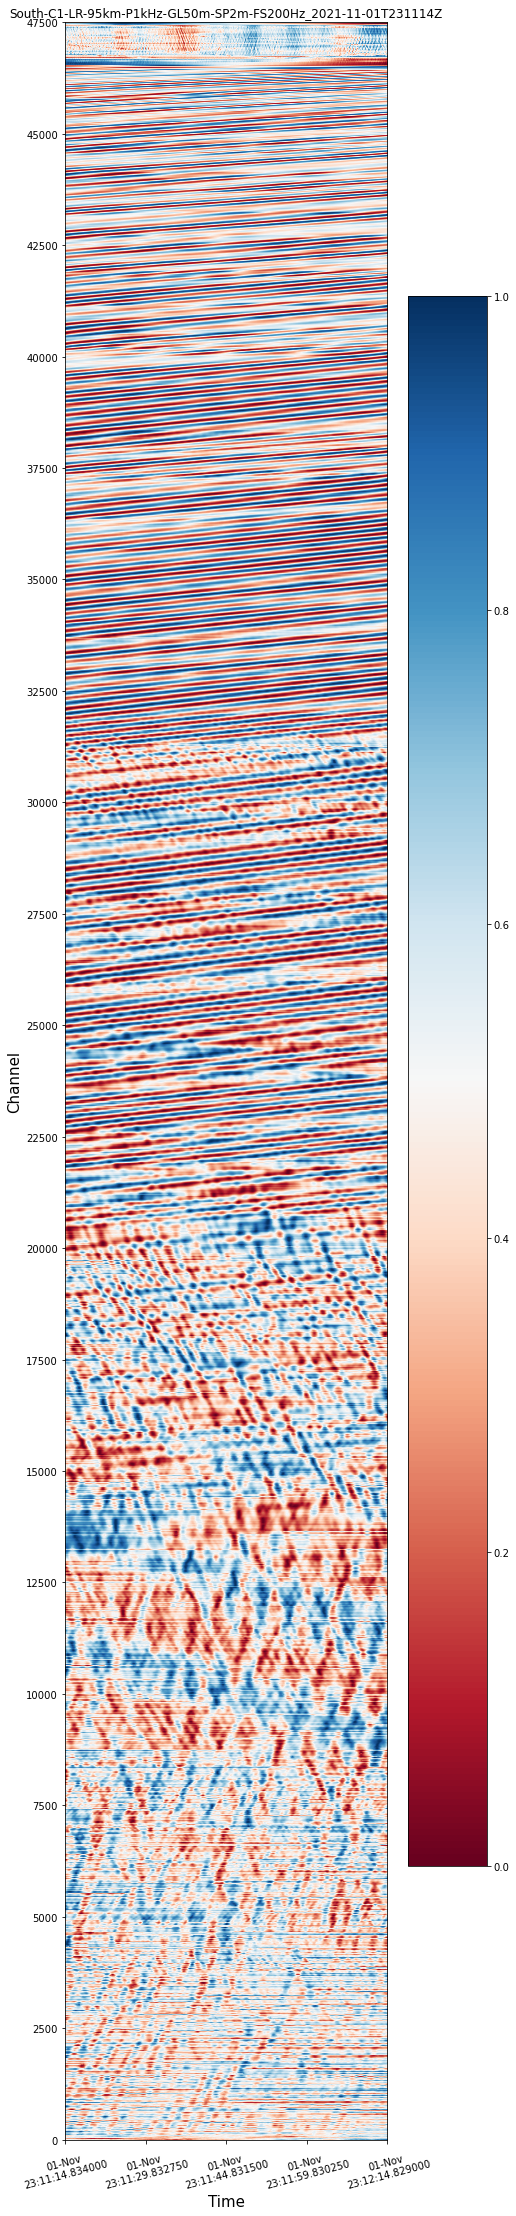

In [4]:
date_format = mdates.DateFormatter('%d-%b\n%H:%M:%S.%f')

downsample_space=10 # At the scale of plotting, the downsampling is imperceptible
downsample_time=10 # At the scale of plotting, the downsampling is imperceptible

x_lims = list(map(datetime.utcfromtimestamp, [timestamp[0], timestamp[-1]]))
x_lims = mdates.date2num(x_lims)
y_lims = [0, 47500]
fig, ax = plt.subplots(figsize = (8, 30))
fig.patch.set_facecolor('white') # Good for dark themed notebooks
plt.tight_layout()
im = ax.imshow((filt_normdata[::downsample_space,::downsample_time]),
               extent = [x_lims[0], x_lims[1],  y_lims[0], y_lims[1]],
               aspect = 1/10405363, cmap = 'RdBu')
ax.xaxis_date()
plt.xlabel("Time", fontsize = 15)
plt.ylabel("Channel", fontsize = 15)
ax.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=15)

plt.xticks(np.linspace(x_lims[0], x_lims[1], 5))
plt.yticks(np.linspace(0, 47500, 20))
plt.title(file.split('.')[0])
plt.colorbar(im, ax = ax, pad = 0.04)
plt.show()


## Display Smoothed File

In [4]:
sliced_output_list=[]
for i in range(16):
  sliced_output_list.append(np.load('C:/Users/laure/Documents/Year 1 (2021 - 2022)/DAS Project/data/gaussian_smoothed_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z_channels_10000to15000_'+str(i)+'.npy'))

In [5]:
smoothed_dat = np.zeros((12000,5000))
for n in range(16):
  smoothed_dat[n*750:(n+1)*750,:] = sliced_output_list[n]

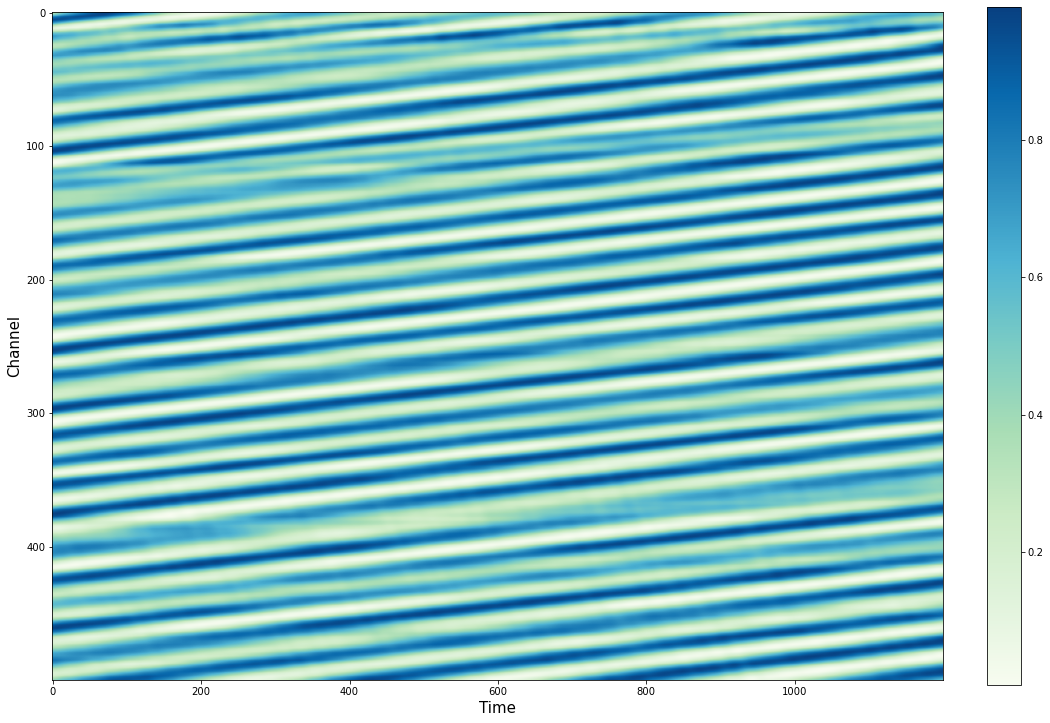

In [7]:
fig, ax = plt.subplots(figsize = (16, 10))
fig.patch.set_facecolor('white') # Good for dark themed notebooks
plt.tight_layout()
im = ax.imshow((smoothed_dat.T[::10,::10]),
                cmap = 'GnBu', aspect = 1.8)
plt.ylabel("Channel", fontsize = 15)
plt.xlabel("Time", fontsize = 15)
plt.colorbar(im, ax = ax, pad = 0.04)
plt.show()

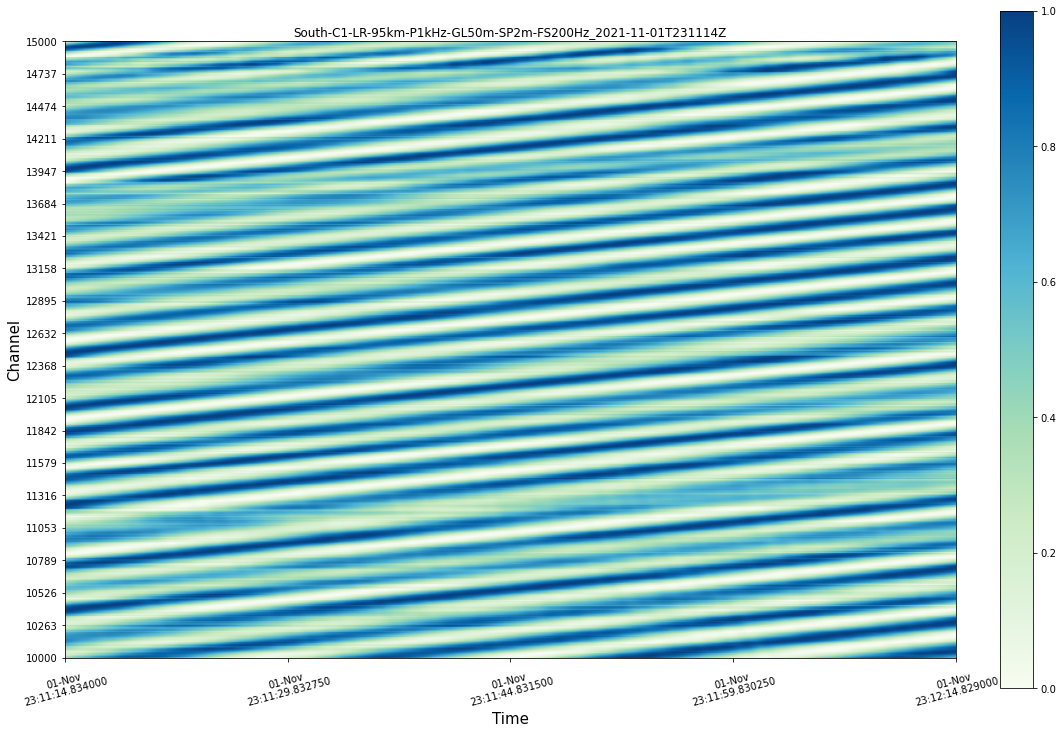

In [8]:
x_lims = list(map(datetime.utcfromtimestamp, [timestamp[0], timestamp[-1]]))
x_lims = mdates.date2num(x_lims)
y_lims = [10000, 15000]
fig, ax = plt.subplots(figsize = (16, 10))
fig.patch.set_facecolor('white') # Good for dark themed notebooks
plt.tight_layout()
im = ax.imshow((filt_normdata[y_lims[0]:y_lims[1]:downsample_space,::downsample_time]),
               extent = [x_lims[0], x_lims[1],y_lims[0],y_lims[1]],#  y_lims[0],y_lims[1]],
               aspect = 1/10405363, cmap = 'GnBu')
ax.xaxis_date()
plt.xlabel("Time", fontsize = 15)
plt.ylabel("Channel", fontsize = 15)
date_format = mdates.DateFormatter('%d-%b\n%H:%M:%S.%f')
ax.xaxis.set_major_formatter(date_format)
plt.xticks(rotation=15)

plt.xticks(np.linspace(x_lims[0], x_lims[1], 5))
plt.yticks(np.linspace(y_lims[0], y_lims[1], 20))
plt.title(file.split('.')[0])
plt.colorbar(im, ax = ax,  pad = 0.04)
plt.show()

## Show smoothing

In [9]:
y_lims = [10000, 15000]
sliced_data = filt_normdata[y_lims[0]:y_lims[1],:]

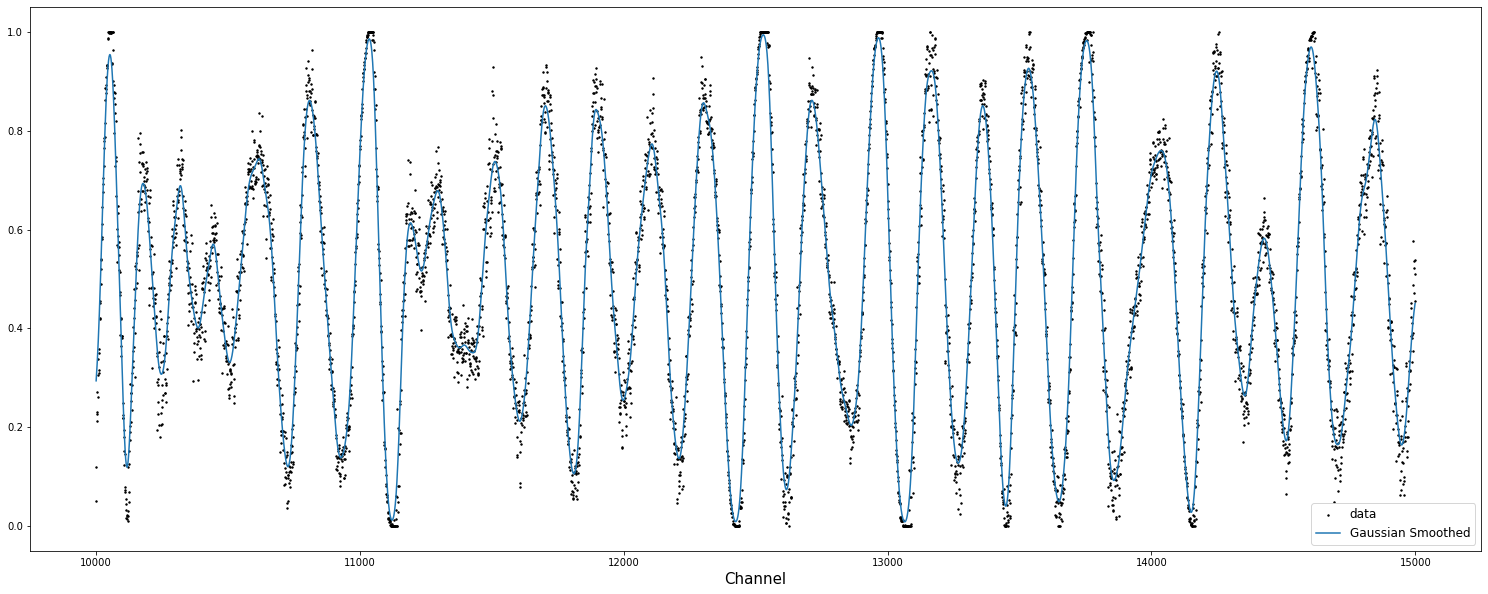

In [10]:
x = np.arange(sliced_data.shape[0])+10000
y_real = sliced_data[:,0]
fig=plt.figure(figsize=(26,10))
plt.scatter(x, sliced_data[:,0],s=2,c='k',label='data')
plt.plot(x,smoothed_dat[0,:], label='Gaussian Smoothed')
plt.xlabel("Channel", fontsize = 15)
plt.legend(fontsize=12)
plt.show()

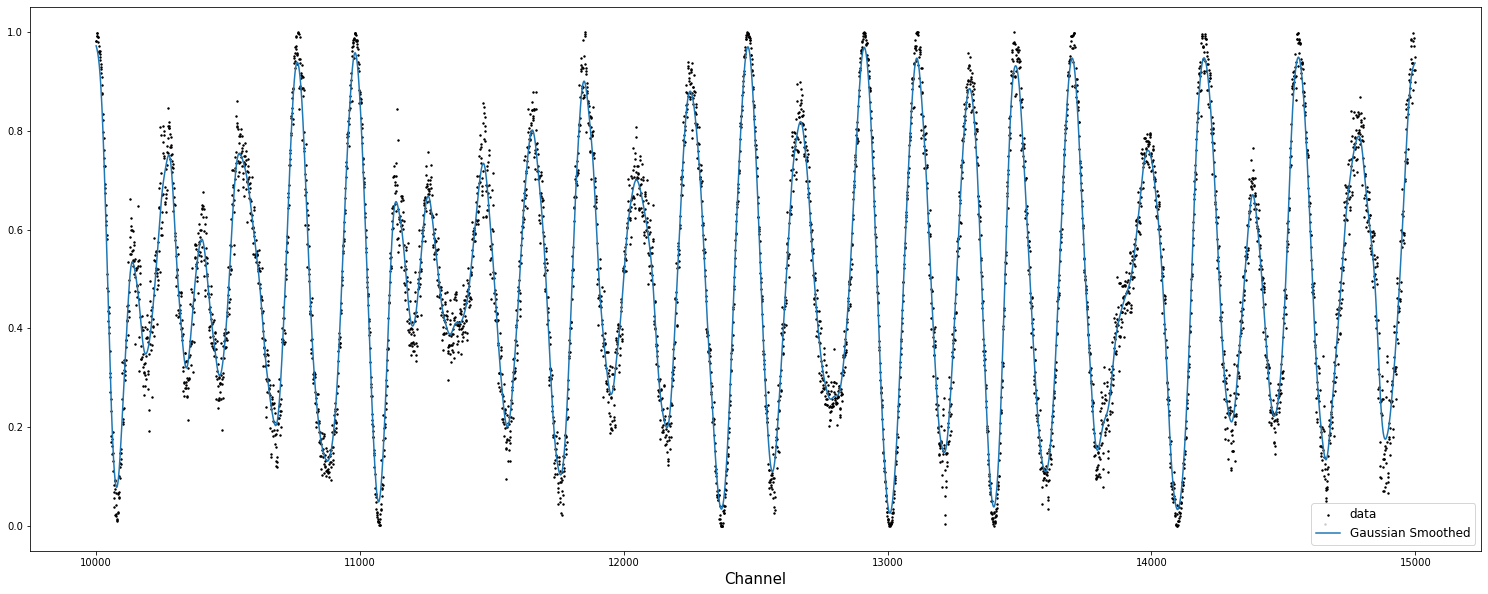

In [11]:
x = np.arange(sliced_data.shape[0])+10000
fig=plt.figure(figsize=(26,10))
plt.scatter(x, sliced_data[:,800],s=2,c='k',label='data')
plt.plot(x,smoothed_dat[800,:], label='Gaussian Smoothed')
plt.xlabel("Channel", fontsize = 15)
plt.legend(fontsize=12)
plt.show()

## PCA

In [6]:
pca = PCA()
transformed = pca.fit(smoothed_dat.T[:,:2000])

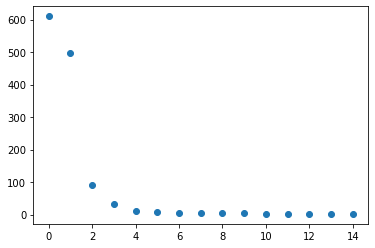

In [7]:
plt.figure()
plt.scatter(np.arange(15), pca.singular_values_[:15])
plt.show()

In [10]:
pca2 = PCA(n_components=2)
transformed = pca2.fit(smoothed_dat.T[:,:2000])
transformed_dat = pca2.transform(smoothed_dat.T[:,:2000])
inverted = pca2.inverse_transform(transformed_dat)

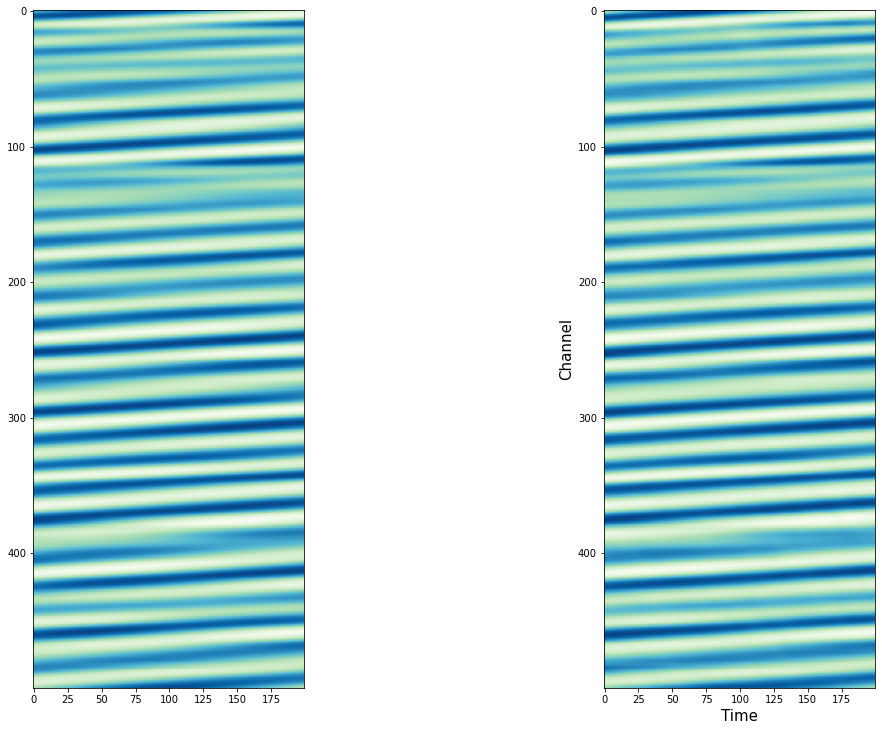

In [18]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize = (16,10))
fig.patch.set_facecolor('white') # Good for dark themed notebooks
plt.tight_layout()

im = ax1.imshow((inverted[::10,::10]),
                cmap = 'GnBu')

im2 = ax2.imshow((smoothed_dat.T[::10,:2000:10]),
                cmap = 'GnBu')
plt.xlabel("Time", fontsize = 15)
plt.ylabel("Channel", fontsize = 15)

plt.colorbar(im, ax = ax, pad = 0.04)
plt.show()

## Smoothing Process on single file

In [ ]:
def gauss_lr(q):
    return lr.localreg(np.arange(len(q)),q, degree=0, kernel=lr.rbf.gaussian, radius=10)

In [ ]:
for n in np.arange(16):
  sliced_df = pd.DataFrame(data=sliced_data[:,n*750:(n+1)*750].T, index=np.arange(750),columns=np.arange(sliced_data.shape[0]))
  sliced_dd = dd.from_pandas(sliced_df, npartitions=4)
  sliced_output = sliced_dd.map_partitions(lambda df: df.apply((lambda row: gauss_lr(row)), axis=1)).compute(scheduler='processes')
  smoothed_slice = np.array([ sliced_output[i] for i in np.arange(750)])
  # np.save('/content/drive/My Drive/Colab Notebooks/gaussian_smoothed_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z_channels_10000to15000_'+str(n),smoothed_slice)